In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bq_helper
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from bq_helper import BigQueryHelper

In [3]:
#creating the gsod database
noaa_gsod = bq_helper.BigQueryHelper(active_project= "bigquery-public-data", 
                                     dataset_name= "noaa_gsod")


In [4]:
#looking at the available tables
bq_assistant = BigQueryHelper("bigquery-public-data", "noaa_gsod")

bq_assistant.list_tables()

['gsod1929',
 'gsod1930',
 'gsod1931',
 'gsod1932',
 'gsod1933',
 'gsod1934',
 'gsod1935',
 'gsod1936',
 'gsod1937',
 'gsod1938',
 'gsod1939',
 'gsod1940',
 'gsod1941',
 'gsod1942',
 'gsod1943',
 'gsod1944',
 'gsod1945',
 'gsod1946',
 'gsod1947',
 'gsod1948',
 'gsod1949',
 'gsod1950',
 'gsod1951',
 'gsod1952',
 'gsod1953',
 'gsod1954',
 'gsod1955',
 'gsod1956',
 'gsod1957',
 'gsod1958',
 'gsod1959',
 'gsod1960',
 'gsod1961',
 'gsod1962',
 'gsod1963',
 'gsod1964',
 'gsod1965',
 'gsod1966',
 'gsod1967',
 'gsod1968',
 'gsod1969',
 'gsod1970',
 'gsod1971',
 'gsod1972',
 'gsod1973',
 'gsod1974',
 'gsod1975',
 'gsod1976',
 'gsod1977',
 'gsod1978',
 'gsod1979',
 'gsod1980',
 'gsod1981',
 'gsod1982',
 'gsod1983',
 'gsod1984',
 'gsod1985',
 'gsod1986',
 'gsod1987',
 'gsod1988',
 'gsod1989',
 'gsod1990',
 'gsod1991',
 'gsod1992',
 'gsod1993',
 'gsod1994',
 'gsod1995',
 'gsod1996',
 'gsod1997',
 'gsod1998',
 'gsod1999',
 'gsod2000',
 'gsod2001',
 'gsod2002',
 'gsod2003',
 'gsod2004',
 'gsod2005',

In [5]:
#defining the query to grab the station table
#the station table has multiples of the same station for lats and longs that 
#are relatively close. 
#I averaged over them so that the stations are unique
query1 = """
            SELECT 
                usaf AS Station_number, 
                lat AS Latitude, 
                lon AS Longitude, 
            FROM 
                `bigquery-public-data.noaa_gsod.stations` 
            WHERE 
                country = 'US' AND lat IS NOT NULL AND lon IS NOT NULL AND NOT (lat = 0.0 AND lon = 0.0) AND NOT usaf = '999999' 
        """

In [8]:
#The commented portion would give all the stations, including repeated ones
#stations = noaa_gsod.query_to_pandas_safe(query1, max_gb_scanned=10)
stations1 = noaa_gsod.query_to_pandas_safe(query1, max_gb_scanned=10)
stations = stations1.copy()
stations = stations.drop(stations.loc[stations.Station_number.duplicated(keep='last')].index)

In [9]:
def gsodquery(year):
    var2 = 'bigquery-public-data.noaa_gsod.gsod'+str(year)
    query = f"""
            SELECT 
                stn AS Station_number, 
                year AS Year, 
                mo AS Month, 
                AVG(temp) as Mean_temp
            FROM 
                {var2} 
            WHERE 
                Stn in {var}
            GROUP BY
                stn, 
                year, 
                mo
        """
    return query

In [12]:
def gsodquerymax(year):
    var2 = 'bigquery-public-data.noaa_gsod.gsod'+str(year)
    query = f"""
            SELECT 
                stn AS Station_number, 
                year AS Year, 
                mo AS Month, 
                AVG(max) as Max_temp
            FROM 
                {var2} 
            WHERE 
                Stn in {var}
            GROUP BY
                stn, 
                year, 
                mo
        """
    return query

In [11]:
var = tuple(stations.Station_number)

In [8]:
gsod1950 = noaa_gsod.query_to_pandas_safe(gsodquery(1950), max_gb_scanned=10)

In [9]:
gsod1970 = noaa_gsod.query_to_pandas_safe(gsodquery(1970), max_gb_scanned=10)

In [10]:
gsod1990 = noaa_gsod.query_to_pandas_safe(gsodquery(1990), max_gb_scanned=10)

In [11]:
gsod2000 = noaa_gsod.query_to_pandas_safe(gsodquery(2000), max_gb_scanned=10)

In [12]:
gsod2020 = noaa_gsod.query_to_pandas_safe(gsodquery(2020), max_gb_scanned=10)

In [16]:
gsod2020max = noaa_gsod.query_to_pandas_safe(gsodquerymax(1950), max_gb_scanned=10)

In [21]:
def latlong(gsod,stations):
    
    lat = np.empty(len(gsod.Station_number))
    long = np.empty(len(gsod.Station_number))
    gsod_copy = gsod.copy()
    for i in range(len(gsod.Station_number)):
        lat[i] = np.array(stations.loc[stations.Station_number == gsod.Station_number[i]].Latitude)[0]
        long[i] = np.array(stations.loc[stations.Station_number == gsod.Station_number[i]].Longitude)[0]
    gsod_copy['Latitude'] = lat
    gsod_copy['Longitude'] = long
    return gsod_copy

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import shapely.geometry as sgeom
import shapely

shapename = 'admin_1_states_provinces_lakes'
states_shp = shpreader.natural_earth(resolution='50m',category='cultural', name=shapename)
    
def mapplot(df,title,feat):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
    ax.set_title(title, fontsize = 16)
    #ax.set_extent([-119, -64, 22, 49], ccrs.Geodetic()) #only plot US map
    ax.set_extent([-121, -72, 21, 50], ccrs.Geodetic()) #only plot US map

    #ax.outline_patch.set_visible(False) #need to find solution to this, depreciated


    for astate in shpreader.Reader(states_shp).records():
        #try:
            # use the name of this state to get pop_density
        geo = [astate.geometry]

            #if astate.attributes['name'] == 'Alaska':
             #   geo = list(map(lambda x: shapely.affinity.scale(x, xfact=0.3, yfact=0.45), [astate.geometry]))
             #   geo = list(map(lambda x: shapely.affinity.translate(x,xoff=40, yoff=-35), geo))
            #if astate.attributes['name'] == 'Hawaii':
             #   geo = list(map(lambda x: shapely.affinity.translate(x,xoff=53, yoff=6), geo))
        #except:
         #   continue

        #`astate.geometry` is the polygon to plot
        ax.add_geometries(geo, ccrs.PlateCarree(),
                          color = 'white', edgecolor='black')
    scat = ax.scatter(df['Longitude'],df['Latitude'], transform=ccrs.PlateCarree(), s=200, zorder=3, c=df[feat], cmap='jet')
    cbar= plt.colorbar(scat, fraction = 0.02)
    cbar.set_label("Temperature", labelpad=+1, fontsize = 20)
    plt.show()
    

            
            
            
            

In [22]:
gsod2020llmax = latlong(gsod2020max,stations)

In [23]:
gsod2020m1max = gsod2020llmax.loc[gsod2020llmax.Month == '01']

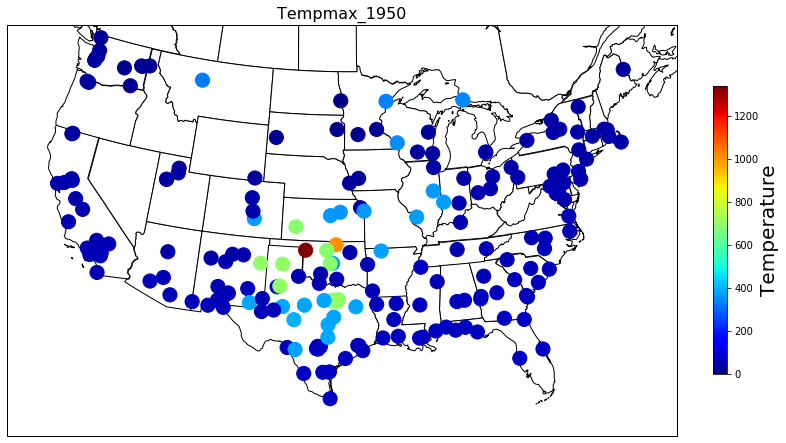

In [26]:
mapplot(gsod2020m1max,'Tempmax_1950','Max_temp')

In [28]:
gsod2020m1max

,Station_number,Year,Month,Max_temp,Latitude,Longitude
0,703080,1950,01,419.057692,57.155,-170.222
31,690110,1950,01,38.853333,42.608,-82.835
35,725816,1950,01,38.853333,40.183,-112.933
39,740030,1950,01,38.853333,40.183,-112.933
52,725959,1950,01,23.400000,41.733,-122.550
...,...,...,...,...,...,...
2673,749071,1950,01,63.296774,36.016,-76.566
2684,749163,1950,01,61.429032,31.933,-108.983
2690,749164,1950,01,56.822581,33.233,-107.017
2691,749165,1950,01,62.732258,31.833,-107.650


In [235]:
gsod1950ll = latlong(gsod1950,stations)

In [236]:
gsod1950m1 = gsod1950ll.loc[gsod1950ll.Month == '01']

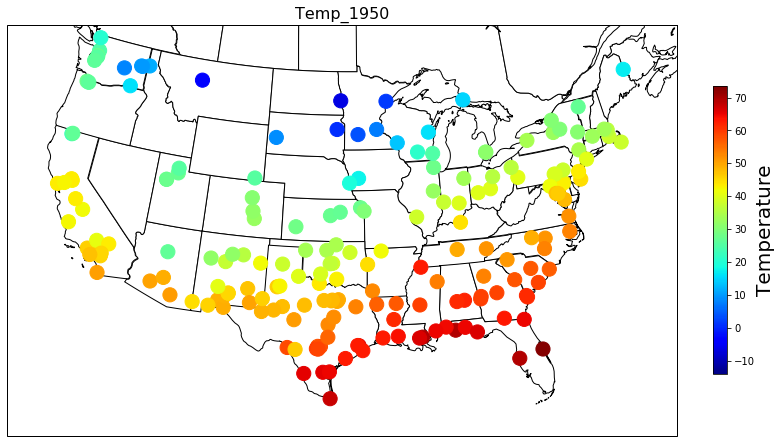

In [238]:
mapplot(gsod1950m1,'Temp_1950')

In [239]:
gsod1970ll = latlong(gsod1970,stations)

In [240]:
gsod1970m1 = gsod1970ll.loc[gsod1970ll.Month == '01']

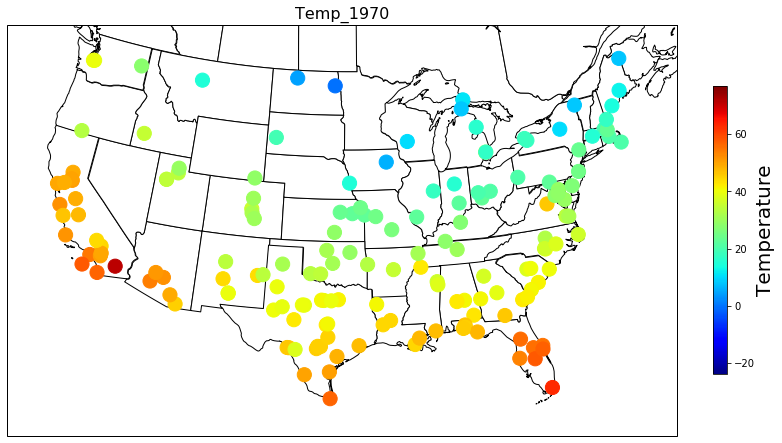

In [241]:
mapplot(gsod1970m1, 'Temp_1970')

In [242]:
gsod1990ll = latlong(gsod1990,stations)

In [243]:
gsod1990m1 = gsod1990ll.loc[gsod1990ll.Month == '01']

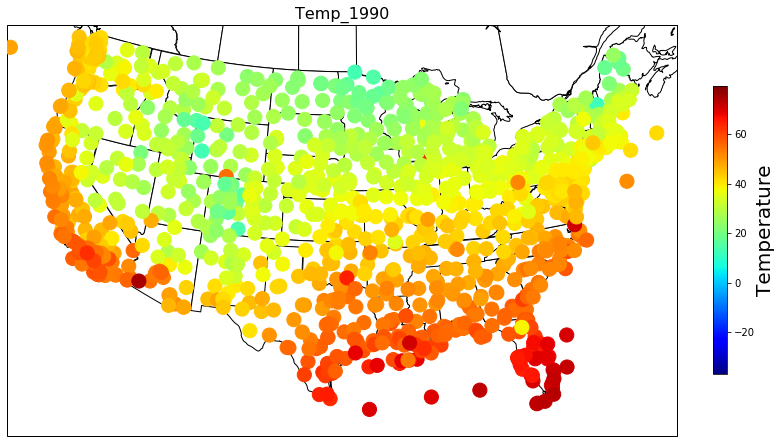

In [244]:
mapplot(gsod1990m1, 'Temp_1990')

In [245]:
gsod2000ll = latlong(gsod2000,stations)

In [246]:
gsod2000m1 = gsod2000ll.loc[gsod2000ll.Month == '02']

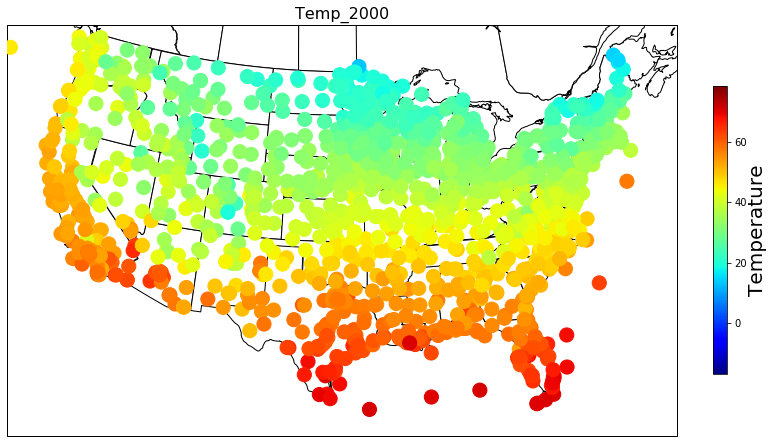

In [247]:
mapplot(gsod2000m1, 'Temp_2000')

In [248]:
gsod2020ll = latlong(gsod2020,stations)

In [249]:
gsod2020m1 = gsod2020ll.loc[gsod2020ll.Month == '03']

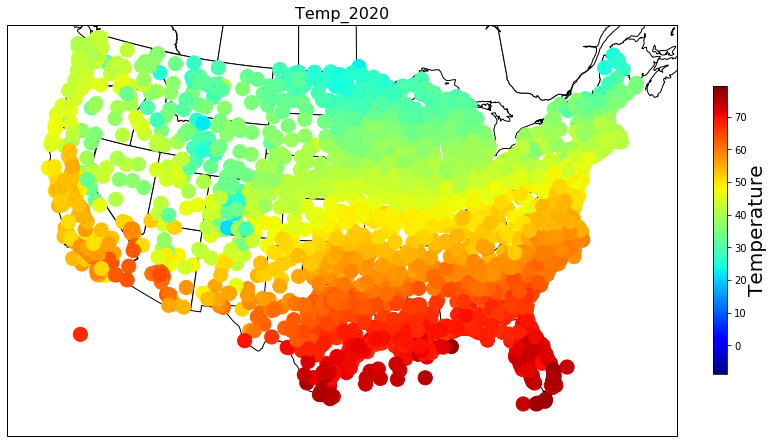

In [250]:
mapplot(gsod2020m1, 'Temp_2020')